# PathPredict Step

- Explore ModelNet40 dataset
- own sampling etc (have to make it better)
- pretrain pointnet++ (as a backbone of paintnet)
- train paintnet

## PointNet train on ModelNet40

TODO: explain more about the dataset (number of train/test split, mormals, etc)

dataset of 40 furnitures

In [1]:
# imports
import open3d as o3d
from data_utils.ModelNet40Loader import ModelNet40
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
dset = ModelNet40(1024, split='test')
print(dset.point_labels)

{0: 'table', 1: 'monitor', 2: 'tv_stand', 3: 'flower_pot', 4: 'sink', 5: 'dresser', 6: 'bottle', 7: 'piano', 8: 'car', 9: 'door', 10: 'toilet', 11: 'range_hood', 12: 'curtain', 13: 'xbox', 14: 'bookshelf', 15: 'guitar', 16: 'glass_box', 17: 'plant', 18: 'stool', 19: 'airplane', 20: 'tent', 21: 'sofa', 22: 'cup', 23: 'cone', 24: 'night_stand', 25: 'stairs', 26: 'lamp', 27: 'desk', 28: 'keyboard', 29: 'vase', 30: 'bowl', 31: 'bed', 32: 'bench', 33: 'laptop', 34: 'person', 35: 'bathtub', 36: 'wardrobe', 37: 'radio', 38: 'mantel', 39: 'chair'}


In [3]:
pc, label = dset[0]
pc = np.asarray(pc)
xyz = pc[:, :3]
normals = pc[:, 3:]

In [4]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz)
pcd.normals = o3d.utility.Vector3dVector(normals)
o3d.visualization.draw_geometries([pcd])

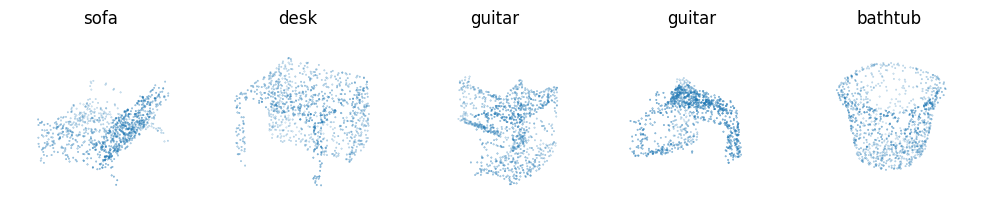

In [73]:
seed = 123124
np.random.seed(seed)

indices = np.random.randint(0, len(dset), 5)
fig = plt.figure(figsize=(10, 10))

# Plot each sampled item
for i, idx in enumerate(indices):
    xyz, class_name = dset[idx]

    # uncommnet if want to show in interactive
    # pcd = o3d.geometry.PointCloud()
    # pcd.points = o3d.utility.Vector3dVector(xyz[:, :3])
    # o3d.visualization.draw_geometries([pcd])

    ax = fig.add_subplot(1, 5, i+1, projection='3d')
    ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], s=0.1)
    ax.set_title(dset.to_class(class_name))
    ax.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz)
o3d.visualization.draw_geometries([pcd])

sample of 5 random furnitures from dataset

We trained pointnet++ on ModelNet40, we use white and biases for logging the results. Model was training for 8h. 
Best acc on 64/200 epoch with val acc 0.9254. We trained pointnet++ with same architecture and parameters like the original paper TODO: link to paper.

`epoch 64: train loss 0.127444, train acc 0.955488, val loss 0.277212, val acc 0.925486 time 147653.14ms
Saving, checkpoint with acc 0.925486 to /home/tiendat/fune/PathPredict3d/out`


In [6]:
from models.pointnet2_cls_ssg import PointNet2ClassificationSSG

device = torch.device('cuda')
model = PointNet2ClassificationSSG(num_category=40)

# loading the model 
outdir = Path('out')
model_path = outdir / "poitnet2_ckpt.pt"
print(f"Resume training from model {model_path}")
ckpt = torch.load(str(model_path))
state_dict = ckpt['model']
unwanted_prefix = '_orig_mod.'
for k, v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
model.load_state_dict(state_dict)
model = model.to(device)
model = model.eval()

Resume training from model out/poitnet2_ckpt.pt


/tmp/ipykernel_86734/1735728663.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(str(model_path))


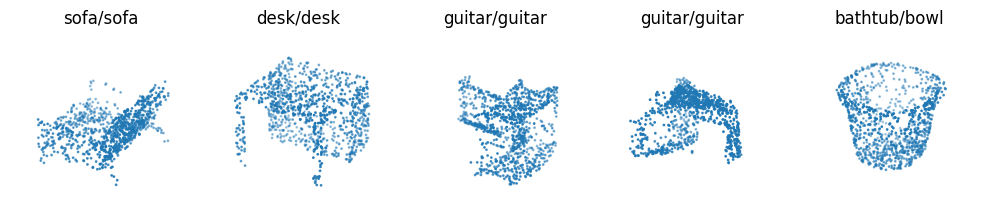

In [68]:
fig = plt.figure(figsize=(10, 10))

for i, idx in enumerate(indices):
    xyz, class_name = dset[idx]
    xyz = torch.from_numpy(xyz).to(torch.float32).to(device)
    xyz = xyz.unsqueeze(0)
    logits = model(xyz)
    pred = logits.argmax(dim=1, keepdim=True).item()
    pred = dset.to_class(pred)
    xyz = np.asarray(xyz.cpu()).squeeze()


    
    ax = fig.add_subplot(1, 5, i+1, projection='3d')
    ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], s=1)
    ax.set_title(f"{dset.to_class(class_name)}/{pred}")
    ax.axis('off')

plt.tight_layout()
plt.show()

first label is ground truth and second label the predicted class. #TODO maybe add all test data

## PaintNet dataset

paintNet made it's own dataset with point cloud and robot program

chamfer distane (calcualtes sum of euclidian distances between two set of points) - good for loss fucntion 

evaluation: F1 - score (precision as points falls into the radius pred -> gt), recall (points falls into the gt -> pred)

https://www.youtube.com/watch?v=S1_nCdLUQQ8&ab_channel=MichiganOnline 59:43 (good video about it)

### Dataset 
 Each pose is collected by sampling from the end-effector kinematics at a rate of 4ms during offline program execution

In [2]:
# Exploring raw dataset 
from paintnet.paintnet_utils import read_mesh_as_pointcloud, read_traj_file
from pathlib import Path

data_dir = Path('/Users/tiendat/fun/thesis-trajplan3d/data/windows-v1/1_wr1fr_1')
obj = data_dir/'1_wr1fr_1.obj'
print(obj)
xyz = read_mesh_as_pointcloud(str(obj), 1024)

traj = data_dir/'trajectory.txt'
traj, traj_id = read_traj_file(str(traj), 'orientnorm')

print(f"Size of trajectory {traj.shape}")

/Users/tiendat/fun/thesis-trajplan3d/data/windows-v1/1_wr1fr_1/1_wr1fr_1.obj

Size of trajectory (15281, 6)


In [18]:
import pyvista as pv
def visualize_mesh_traj(meshfile,
                        traj,
                        plotter=None,
                        index=None,
                        text=None,
                        trajc='lightblue',
                        trajvel=False,
                        lambda_points=1,
                        camera=None,
                        extra_data=[],
                        stroke_ids=None,
                        cmap=None,
                        arrow_color=None):
    """Visualize mesh-traj pair

    meshfile: str
              mesh filename.obj
    traj : (N,k) array
    
    lambda_points: traj is set of sequences of lambda_points
    """
    curr_traj = traj.copy()

    show_plot = True

    plotter = pv.Plotter(shape=(1, 1), window_size=(1920,1080))
    plotter.subplot(0,0)

    mesh_obj = pv.read(meshfile)
    plotter.add_mesh(mesh_obj)

    if torch.is_tensor(curr_traj):
        curr_traj = curr_traj.cpu().detach().numpy()

    if lambda_points > 1:
        outdim = get_dim_traj_points(extra_data)
        assert curr_traj.shape[-1]%outdim == 0
        curr_traj = curr_traj.reshape(-1, outdim)
        curr_traj = remove_padding(curr_traj, extra_data)  # makes sense only if it's GT traj, but doesn't hurt

    traj_pc = pv.PolyData(curr_traj[:, :3])

    cmap = handle_cmap_input(cmap)

    plotter.add_mesh(traj_pc,
                     color=trajc,
                     # scalars=(None if stroke_ids is None else 60*np.sin(2*math.pi*(1/12)*stroke_ids)),
                     scalars=stroke_ids,
                     point_size=14.0,
                     opacity=1.0,
                     render_points_as_spheres=True,
                     cmap=cmap)

    if trajvel:
        assert 'vel' in extra_data, 'Cannot display traj velocity: trajectory does not contain velocities'
        plotter.add_arrows(curr_traj[:, :3], curr_traj[:, 3:6], mag=1, color='green', opacity=0.8)

    if orient_in(extra_data)[0]:
        orient_repr = orient_in(extra_data)[1]
        indexes = get_traj_feature_index(orient_repr, extra_data)

        e1 = np.array([1, 0, 0])
        rots = rot_from_representation(orient_repr, curr_traj[:, indexes])
        e1_rots = rots.apply(e1)
        down_scale_factor = 10
        e1_rots /= down_scale_factor

        if arrow_color is None:
            arrow_color = 'red'

        plotter.add_arrows(curr_traj[:, :3]-e1_rots, e1_rots, mag=1, color=arrow_color, opacity=0.8)

    if camera is not None:
        plotter.set_position(camera)
    if text is not None:
        plotter.add_text(text)
    if show_plot:
        plotter.show_axes()
        plotter.show()
    return

def handle_cmap_input(cmap):
    if cmap == 'gt':
        cmap = ['#D84315', '#F57C00', '#FFB300', '#FFEB3B']
    elif cmap == 'pred':
        cmap = ['#2C3E50', '#16A085', '#27AE60', '#2980B9', '#8E44AD']

    return cmap

def orient_in(extra_data):
    """Whether each output pose includes orientations.
    
    Returns the specific orient representation as well.
    """
    valid = ['orientquat', 'orientrotvec', 'orientnorm']
    for v in valid:
        if v in extra_data:
            return True, v
    
    return False, None

def get_traj_feature_index(feat, extra_data):
    if feat == None:
        return None

    if len(extra_data) == 0:
        indexes = {
            'pos': [0, 1, 2],
            'vel': None,
            'orientquat': None,
            'orientrotvec': None,
            'orientnorm': None
        }
    elif 'vel' in extra_data and len(extra_data) == 1:  # Vel only
        indexes = {
            'pos': [0, 1, 2],
            'vel': [3, 4, 5],
            'orientquat': None,
            'orientrotvec': None,
            'orientnorm': None
        }
    elif 'orientquat' in extra_data and len(extra_data) == 1:  # Orient only
        indexes = {
            'pos': [0, 1, 2],
            'vel': None,
            'orientquat': [3, 4, 5, 6],
            'orientrotvec': None,
            'orientnorm': None
        }
    elif 'orientrotvec' in extra_data and len(extra_data) == 1:  # Orient only
        indexes = {
            'pos': [0, 1, 2],
            'vel': None,
            'orientquat': None,
            'orientrotvec': [3, 4, 5],
            'orientnorm': None
        }
    elif 'orientnorm' in extra_data and len(extra_data) == 1:  # Orient only
        indexes = {
            'pos': [0, 1, 2],
            'vel': None,
            'orientquat': None,
            'orientrotvec': None,
            'orientnorm': [3, 4, 5]
        }
    else:
        raise ValueError('Other combinations of extra_data are not supported yet.')

    return indexes[feat]
    
def rot_from_representation(orient_repr, arr):
    if orient_repr == 'orientquat':
        return Rot.from_quat(arr)
    elif orient_repr == 'orientrotvec':
        return Rot.from_rotvec(arr)
    elif orient_repr == 'orientnorm':
        return FakeRot(arr)


class FakeRot():
    """Mimics Rot object from scipy, to apply rotations in terms of normals
    (2D pose representation for points)"""
    def __init__(self, normals):
        self.normals = normals

    def apply(self, *args, **kwargs):
        return self.normals

In [20]:
%load_ext autoreload
%autoreload 2
# from paintnet.paintnet_utils import visualize_mesh, visualize_complete_traj, visualize_sequence_traj
# visualize_mesh_traj(str(obj), traj, traj_id, extra_data=['orientnorm'])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(xyz)
o3d.visualization.draw_geometries([pcd])

[Open3D WARNING] GLFW Error: Cocoa: Failed to find service port for display


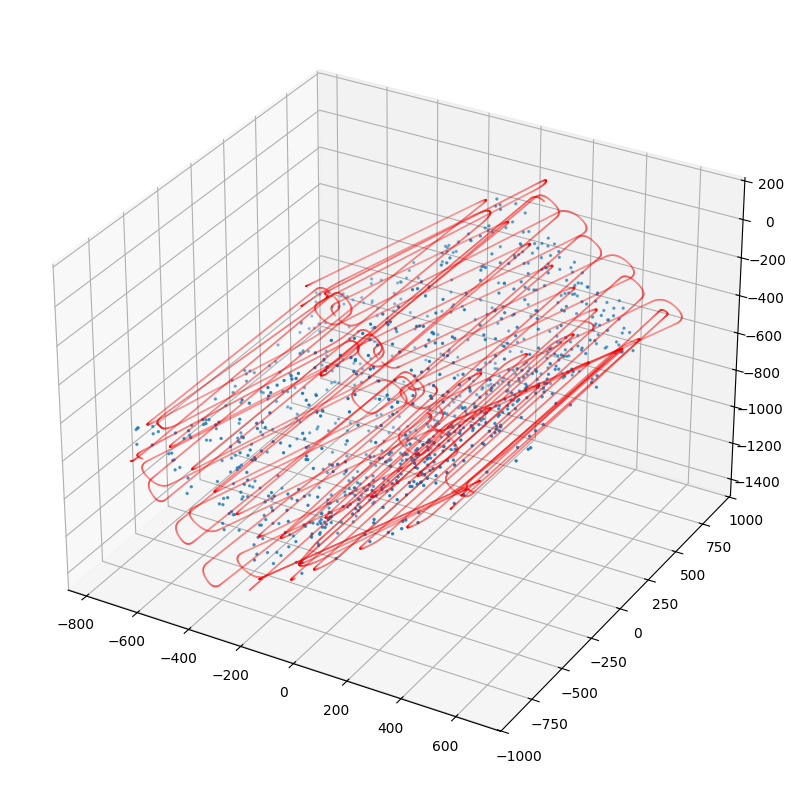

In [6]:
fig = plt.figure(figsize=(10,10))

# TODO -> better visualisation

# Create a 3D subplot
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xyz[:, 0], xyz[:, 1], xyz[:, 2], s=2);
ax.scatter(traj[:, 0], traj[:, 1], traj[:, 2], s=0.01, c='r', alpha=0.5);